
# Feature transformations with ensembles of trees

Transform your features into a higher dimensional, sparse space. Then train a
linear model on these features.

First fit an ensemble of trees (totally random trees, a random forest, or
gradient boosted trees) on the training set. Then each leaf of each tree in the
ensemble is assigned a fixed arbitrary feature index in a new feature space.
These leaf indices are then encoded in a one-hot fashion.

Each sample goes through the decisions of each tree of the ensemble and ends up
in one leaf per tree. The sample is encoded by setting feature values for these
leaves to 1 and the other feature values to 0.

The resulting transformer has then learned a supervised, sparse,
high-dimensional categorical embedding of the data.


In [14]:
# Author: Tim Head <betatim@gmail.com>
#
# License: BSD 3 clause

First, we will create a large dataset and split it into three sets:

- a set to train the ensemble methods which are later used to as a feature
  engineering transformer;
- a set to train the linear model;
- a set to test the linear model.

It is important to split the data in such way to avoid overfitting by leaking
data.



In [15]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=80_000, random_state=10)

X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=10
)
X_train_ensemble, X_train_linear, y_train_ensemble, y_train_linear = train_test_split(
    X_full_train, y_full_train, test_size=0.5, random_state=10
)

In [16]:
import pandas as pd
df=pd.read_csv('Resources/data.csv',delimiter=';')
#labels=list(df['Target'].unique())
df['Target'] = pd.Categorical(df['Target'])
df['Target'] = df['Target'].cat.codes
print(df['Target'].value_counts())
df.head()

Target
2    2209
0    1421
1     794
Name: count, dtype: int64


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,2
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,2
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,2


In [17]:
categorical_df=df.drop(columns=['GDP', 'Inflation rate', 'Unemployment rate', 'Admission grade', 'Previous qualification (grade)','Target'])
categorical_columns=list(categorical_df.columns)

In [18]:
y=df['Target']
X=df.drop(columns='Target')

In [19]:
X=pd.get_dummies(X,columns=categorical_columns).astype(int)
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=10
)
X_train_ensemble, X_train_linear, y_train_ensemble, y_train_linear = train_test_split(
    X_full_train, y_full_train, test_size=0.5, random_state=10
)

For each of the ensemble methods, we will use 10 estimators and a maximum
depth of 3 levels.



In [20]:
n_estimators = 10
max_depth = 3

First, we will start by training the random forest and gradient boosting on
the separated training set



In [21]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

random_forest = RandomForestClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)
random_forest.fit(X_train_ensemble, y_train_ensemble)

gradient_boosting = GradientBoostingClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)
_ = gradient_boosting.fit(X_train_ensemble, y_train_ensemble)

Notice that :class:`~sklearn.ensemble.HistGradientBoostingClassifier` is much
faster than :class:`~sklearn.ensemble.GradientBoostingClassifier` starting
with intermediate datasets (`n_samples >= 10_000`), which is not the case of
the present example.

The :class:`~sklearn.ensemble.RandomTreesEmbedding` is an unsupervised method
and thus does not required to be trained independently.



In [22]:
from sklearn.ensemble import RandomTreesEmbedding

random_tree_embedding = RandomTreesEmbedding(
    n_estimators=n_estimators, max_depth=max_depth, random_state=0
)

Now, we will create three pipelines that will use the above embedding as
a preprocessing stage.

The random trees embedding can be directly pipelined with the logistic
regression because it is a standard scikit-learn transformer.



In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

rt_model = make_pipeline(random_tree_embedding, LogisticRegression(max_iter=1000))
rt_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('randomtreesembedding',
                 RandomTreesEmbedding(max_depth=3, n_estimators=10,
                                      random_state=0)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Then, we can pipeline random forest or gradient boosting with a logistic
regression. However, the feature transformation will happen by calling the
method `apply`. The pipeline in scikit-learn expects a call to `transform`.
Therefore, we wrapped the call to `apply` within a `FunctionTransformer`.



In [24]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder


def rf_apply(X, model):
    return model.apply(X)


rf_leaves_yielder = FunctionTransformer(rf_apply, kw_args={"model": random_forest})

rf_model = make_pipeline(
    rf_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000),
)
rf_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function rf_apply at 0x00000166387AA3E0>,
                                     kw_args={'model': RandomForestClassifier(max_depth=3,
                                                                              n_estimators=10,
                                                                              random_state=10)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [25]:
def gbdt_apply(X, model):
    return model.apply(X)[:, :, 0]


gbdt_leaves_yielder = FunctionTransformer(
    gbdt_apply, kw_args={"model": gradient_boosting}
)

gbdt_model = make_pipeline(
    gbdt_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000),
)
gbdt_model.fit(X_train_linear, y_train_linear)

c:\Users\p0pp1\miniconda3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function gbdt_apply at 0x0000016613E109A0>,
                                     kw_args={'model': GradientBoostingClassifier(n_estimators=10,
                                                                                  random_state=10)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

We can finally show the different ROC curves for all the models.



ValueError: Expected 'estimator' to be a binary classifier. Got 3 classes instead.

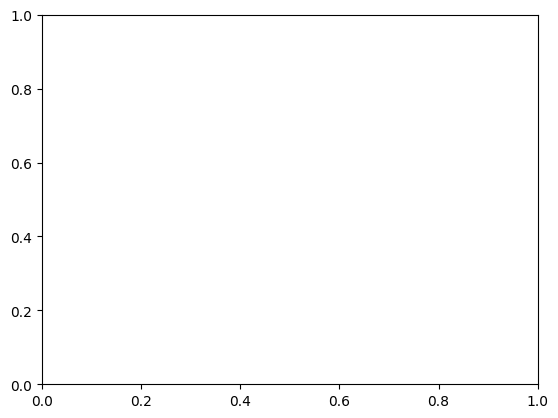

In [26]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()

models = [
    ("RT embedding -> LR", rt_model),
    ("RF", random_forest),
    ("RF embedding -> LR", rf_model),
    ("GBDT", gradient_boosting),
    ("GBDT embedding -> LR", gbdt_model),
]

model_displays = {}
for name, pipeline in models:
    model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, X_test, y_test, ax=ax, name=name
    )
_ = ax.set_title("ROC curve")

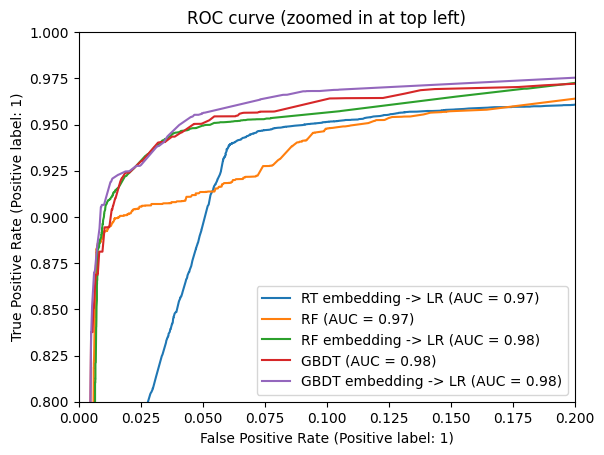

In [ ]:
fig, ax = plt.subplots()
for name, pipeline in models:
    model_displays[name].plot(ax=ax)

ax.set_xlim(0, 0.2)
ax.set_ylim(0.8, 1)
_ = ax.set_title("ROC curve (zoomed in at top left)")